In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.isnull().sum()[train.isnull().sum() > 1]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

### Correlation Matrix 

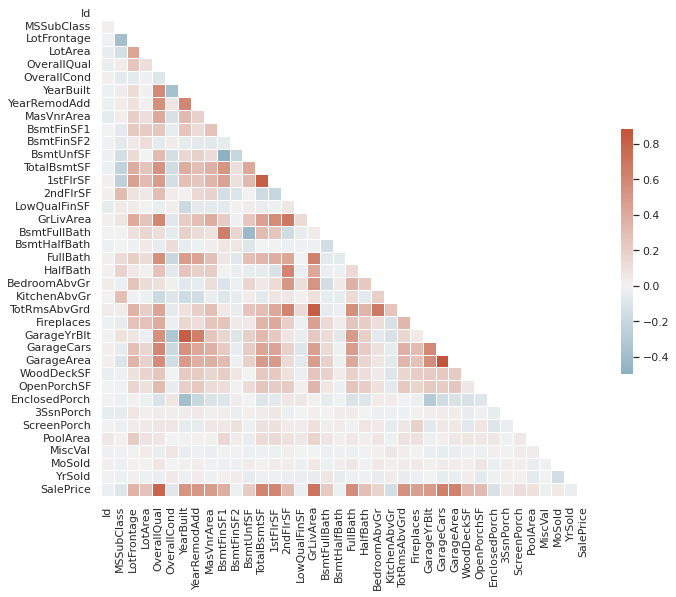

In [5]:
sns.set_theme(style="white")
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### So, 1stFlrSF has a good positive correlation with TotalBsmtSF 

In [6]:
train.corr()['1stFlrSF'][(train.corr()['1stFlrSF'] > 0.6) | (train.corr()['1stFlrSF'] < -0.6)]\
    .sort_values(ascending=False)

1stFlrSF       1.000000
TotalBsmtSF    0.819530
SalePrice      0.605852
Name: 1stFlrSF, dtype: float64

In [7]:
best_features_correlations = train.corr()['SalePrice'][(train.corr()['SalePrice'] > 0.6)\
                                                       | (train.corr()['SalePrice'] < -0.6)]\
                                                        .sort_values().index

In [8]:
train[best_features_correlations].head()

,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,SalePrice
0,856,856,548,2,1710,7,208500
1,1262,1262,460,2,1262,6,181500
2,920,920,608,2,1786,7,223500
3,961,756,642,3,1717,7,140000
4,1145,1145,836,3,2198,8,250000


### Data Preparing 

##### LotFrontage 

In [9]:
LotFrontage_mean = train['LotFrontage'].describe().mean()
train['LotFrontage'].fillna(LotFrontage_mean, inplace=True)

##### Alley

In [10]:
train[train['Alley'].notnull()]['Alley'].describe()

count       91
unique       2
top       Grvl
freq        50
Name: Alley, dtype: object

In [11]:
set(train[train['Alley'].notnull()]['Alley'])

{'Grvl', 'Pave'}

In [12]:
Alley_values_dict = {
    'Pave': 2,
    'Grvl': 1,
    'None': 0
}

In [13]:
train['Alley'].fillna('None', inplace=True)
train['Alley'] = train['Alley'].apply(lambda x: Alley_values_dict[x])

In [14]:
set(train['Alley'])

{0, 1, 2}

##### MasVnrType 

In [15]:
set(train['MasVnrType'])

{'BrkCmn', 'BrkFace', 'None', 'Stone', nan}

##### MasVnrArea 

In [16]:
train['MasVnrArea'].fillna(0, inplace=True)

##### BsmtQual

In [17]:
set(train['BsmtQual'])

{'Ex', 'Fa', 'Gd', 'TA', nan}

In [18]:
estimates = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'No': 0
}

In [19]:
train['BsmtQual'].fillna('No', inplace=True)
train['BsmtQual'] = train['BsmtQual'].apply(lambda x: estimates[x])

##### BsmtCond

In [20]:
train['BsmtCond'].fillna('No', inplace=True)
train['BsmtCond'] = train['BsmtCond'].apply(lambda x: estimates[x])

##### BsmtExposure

In [21]:
BsmtCond_estimates = {
    'Gd': 4,
    'Av': 3,
    'Mn': 2,
    'No': 0
}

In [22]:
train['BsmtExposure'].fillna('No', inplace=True)
train['BsmtExposure'] = train['BsmtExposure'].apply(lambda x: BsmtCond_estimates[x])

##### BsmtFinType1

In [23]:
BsmtFinType1_estimates = {
    'GLQ': 5,
    'ALQ': 4,
    'BLQ': 3,
    'Rec': 2,
    'LwQ': 1,
    'Unf': 0,
    'No': 0
}

In [24]:
train['BsmtFinType1'].fillna('No', inplace=True)
train['BsmtFinType1'] = train['BsmtFinType1'].apply(lambda x: BsmtFinType1_estimates[x])

##### BsmtFinType2

In [25]:
train['BsmtFinType2'].fillna('No', inplace=True)
train['BsmtFinType2'] = train['BsmtFinType2'].apply(lambda x: BsmtFinType1_estimates[x])

##### FireplaceQu  

In [26]:
train['FireplaceQu'].fillna('No', inplace=True)
train['FireplaceQu'] = train['FireplaceQu'].apply(lambda x: estimates[x])

##### GarageType

In [27]:
GarageType_estimates = {
    '2Types': 6,
    'Attchd': 5,
    'Basment': 4,
    'BuiltIn': 3,
    'CarPort': 2,
    'Detchd': 1,
    'No': 0
}

In [28]:
train['GarageType'].fillna('No', inplace=True)
train['GarageType'] = train['GarageType'].apply(lambda x: GarageType_estimates[x])

##### GarageYrBlt

In [29]:
max_garageYrBlt = max(train['GarageYrBlt'])
train['GarageYrBlt'].fillna(0, inplace=True)
train['GarageYrBlt'] = train['GarageYrBlt'].apply(lambda x: x/max_garageYrBlt)

##### GarageFinish

In [30]:
GarageFinish_estimates = {
    'Fin': 4,
    'RFn': 3,
    'Unf': 2,
    'No': 0
}

In [31]:
train['GarageFinish'].fillna('No', inplace=True)
train['GarageFinish'] = train['GarageFinish'].apply(lambda x: GarageFinish_estimates)

##### GarageQual

In [32]:
train['GarageQual'].fillna('No', inplace=True)
train['GarageQual'] = train['GarageQual'].apply(lambda x: estimates[x])

##### GarageCond 

In [33]:
train['GarageCond'].fillna('No', inplace=True)
train['GarageCond'] = train['GarageCond'].apply(lambda x: estimates[x])

##### PoolQC 

In [34]:
train['PoolQC'].fillna('No', inplace=True)
train['PoolQC'] = train['PoolQC'].apply(lambda x: estimates[x])

##### Fence 

In [35]:
Fence_estimates = {
    'GdPrv': 5,
    'MnPrv': 4,
    'GdWo': 3,
    'MnWw': 2,
    'No': 0
}

In [36]:
train['Fence'].fillna('No', inplace=True)
train['Fence'] = train['Fence'].apply(lambda x: Fence_estimates[x])

##### MiscFeature 

In [37]:
MiscFeature_estimates = {
    'Elev': 5,
    'Gar2': 4,
    'Othr': 3,
    'Shed': 2,
    'TenC': 1,
    'No': 0
}

In [38]:
train['MiscFeature'].fillna('No', inplace=True)
train['MiscFeature'] = train['MiscFeature'].apply(lambda x: MiscFeature_estimates[x])

#### Now let's have a look at heatmap again 

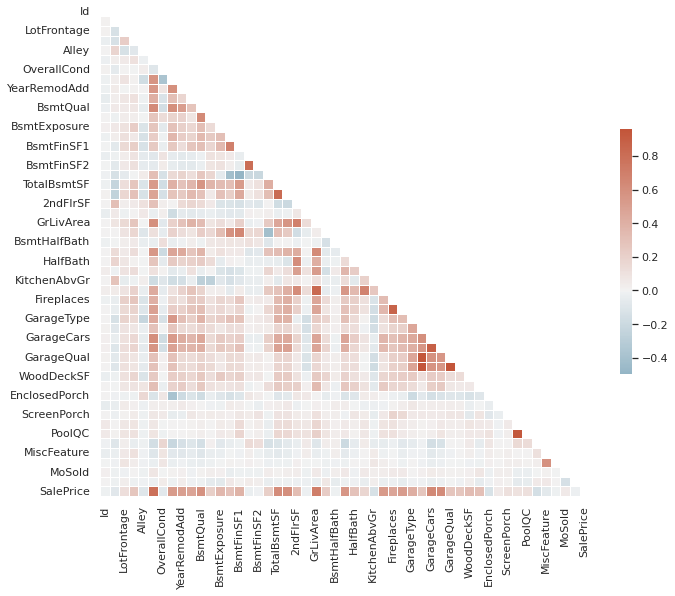

In [39]:
sns.set_theme(style="white")
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

##### Again look at the best features 

In [60]:
best_features_correlations = train.corr()['SalePrice'][(train.corr()['SalePrice'] > 0.6)\
                                                       | (train.corr()['SalePrice'] < -0.6)]\
                                                        .sort_values().index

In [62]:
train[best_features_correlations].head()

,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,SalePrice
0,856,856,548,2,1710,7,208500
1,1262,1262,460,2,1262,6,181500
2,920,920,608,2,1786,7,223500
3,961,756,642,3,1717,7,140000
4,1145,1145,836,3,2198,8,250000


##### Okay, there is no diferences
#### Trying to have a look at graphs

KeyError: "None of [Int64Index([ 60,  20,  60,  70,  60,  50,  20,  60,  50, 190,\n            ...\n             90,  20, 180,  20,  20,  60,  20,  70,  20,  20],\n           dtype='int64', length=1460)] are in the [columns]"

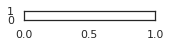

In [79]:
plt.figure(figsize=(8,16))

for i in range(1, train.shape[1]-1):
    plt.subplot(train.shape[1]-2, 3, i)
    plt.plot(train[train[train.columns[i]]], train['SalePrice'])
    plt.title(train.columns[i])
    
plt.show()

TypeError: unhashable type: 'dict'

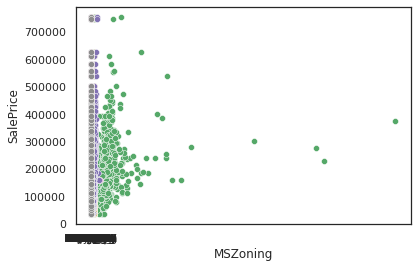

In [83]:
for i in range(1,len(train.columns)-1):
    sns.scatterplot(data=train, x=train.columns[1:-1][i], y='SalePrice')

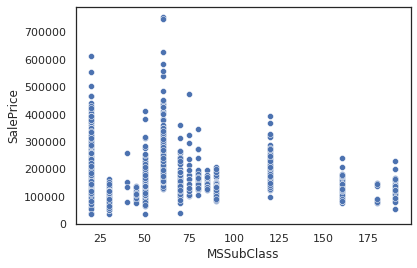

In [66]:
sns.scatterplot(data=train, x=train.columns[1:-1][0], y='SalePrice')

### Trying to training model 

In [55]:
X = train[best_features_correlations[:-1]]
y = train[best_features_correlations[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)
y_predictors = model.predict(X_test)
mean_absolute_error(y_test, y_predictors)

24914.265615651802